In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Luke Bouma assumes 1 count = 1 photon = 1 electron (not true if farther from boresight)

In [4]:
class NoiseModel():
    
    def __init__(self, Tmag, Texp, Aper, coord=None, unit='ppm'):
        self.Tmag = Tmag # TESS magnitude of target
        self.Texp = Texp # exposure time
        self.Aper = Aper # aperture
        
        # use coordinates to calculate ecliptic latitute
        if coord is None: 
            self.EcLat = 30.
            
        self.noise_unit = unit
     
    def cts2unit(self):
        
        if self.noise_unit == 'ppm':
            factor = 1./self.star_counts()*1e6
        elif self.noise_unit == 'percent':
            factor = 1./self.star_counts()*1e2
        elif self.noise_unit == 'fraction':
            factor = 1./self.star_counts()
        else:
            raise           
        return factor

    def ctsperpix2unit(self):
        
        factor = self.cts2unit() * self.Aper
        return factor

    # Star flux (returns counts if all light included in aperture)        
    def star_counts(self):
        
        # counts for a Tmag = 0 source
        SB0 = 1.514e6 # photons / s / cm2
        F0 = SB0 * 69 # TESS aperture is 69 cm2

        Fstar = F0 * np.power(10, -0.4 * self.Tmag ) # photons / s for star
        return Fstar * self.Texp

    # Poisson noise from star (returns counts)
    def star_noise(self):
        # star noise
        Fstar = self.star_counts()
        #return np.sqrt(Fstar) # photons
        return np.sqrt(Fstar) * self.cts2unit() # ppm
    
    # Read noise (returns e- /pix)
    def read_noise(self):
        
        nexp = self.Texp/2. 
        #print "N exposures", nexp
        #print 10.*np.sqrt(nexp) # e- / pix
        return 10.*np.sqrt(self.Aper*nexp) * self.cts2unit() # ppm
    
    # Systematic noise floor
    def sys_noise(self):
        
        noise_floor = 60 # ppm per hour
        tmp = 60 * np.power(self.Texp/60./60., -0.5) # ppm
        if self.noise_unit == 'ppm':
            sys = tmp
        elif self.noise_unit == 'percent':
            sys = tmp*1e-4
        return sys
    
    # Zodiacal Light contribution (returns e- / pix)
    def zodi_noise(self):

        # V = V-band surface brightness of zodiacal light in mag/arcsec2
        Vmax = 23.345
        deltaV = 1.148
        
        V = Vmax - deltaV * (self.EcLat/90 - 1)**2 
        ZL_flux = 2.56e-3 * np.power(10, -0.4*(V-22.8)) # photons / s / cm2 / arcsec2
        ZL_rec = ZL_flux * 69 * 21.1**2 # TESS aperture is 69 cm2, pixels are 21 arcsec/cm

        # should get 95-270 e- / pix in a 2 sec exposure - checks out
        #return ZL_rec*self.Texp # e- / pix    
        return np.sqrt(ZL_rec*self.Texp * self.Aper) * self.cts2unit() # ppm

    
    # Total noise (relative to flux from star)
    def tot_noise(self):
    
        star = star_noise()
        read = read_noise()
        zodi = zodi_noise()
        sys = sys_noise()
        
        return star + read + zodi + sys
        
        



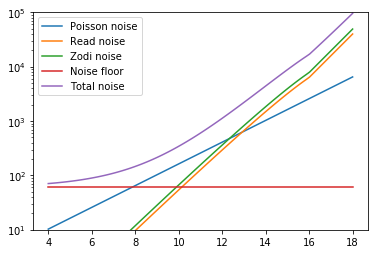

In [3]:
# tbis replicates the one in the Sullivan paper

Tmags = np.linspace(4,18,100)
read = np.zeros_like(Tmags)
zodi = np.zeros_like(Tmags)
star = np.zeros_like(Tmags)
sys = np.zeros_like(Tmags)

for i,t in enumerate(Tmags):
    
    optAper = 35 - (t-6)*3.
    if optAper < 5:
        optAper = 5
    if optAper > 35:
        optAper = 35
    
    myNM = NoiseModel(t, 60.*60, optAper, unit='ppm')
    star[i] = myNM.star_noise()
    read[i] = myNM.read_noise()
    zodi[i] = myNM.zodi_noise()
    sys[i] = myNM.sys_noise()

plt.plot(Tmags, star, label='Poisson noise')
plt.plot(Tmags, read, label='Read noise')
plt.plot(Tmags, zodi, label='Zodi noise')
plt.plot(Tmags, sys, label='Noise floor')
plt.plot(Tmags, star+read+zodi+sys, label='Total noise')
plt.yscale('log')
plt.ylim(1e1, 1e5)
plt.legend()
plt.show()

In [4]:
sys

# rough opitmal aperture approximated from the bottom of Fig. 14 in Sullivan paper
#y = 35 - (Tmags-6)*3.
#plt.plot(Tmags, y)
#plt.show()

array([ 60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,
        60.])

In [9]:
for i in [3]:
    
    # Exposure time in min.
    if i == 0:
        Texp = 2.*60
        loc = 'lower right'
    elif i == 1:
        Texp = 60.*60
        loc = 'lower left'
    elif i == 2:
        Texp = 12*60.*60
        loc = 'upper left'
    elif i == 3: # 2 sec
        Texp = 2
        loc = 'lower right'

    Tmags = np.linspace(6,18,100)
    read = np.zeros_like(Tmags)
    zodi = np.zeros_like(Tmags)
    star = np.zeros_like(Tmags)
    sys = np.zeros_like(Tmags)

    for ii,t in enumerate(Tmags):

        optAper = 35 - (t-6)*3.
        if optAper < 3:
            optAper = 3
        if optAper > 35:
            optAper = 35

        myNM = NoiseModel(t, Texp, optAper, unit='percent')
        star[ii] = myNM.star_noise()
        read[ii] = myNM.read_noise()
        zodi[ii] = myNM.zodi_noise()
        sys[ii] = myNM.sys_noise()

    plt.figure()
    plt.plot(Tmags, star, label='Stellar Poisson noise')
    plt.plot(Tmags, read, label='Read noise')
    plt.plot(Tmags, zodi, label='Zodiacal Light')
    plt.plot(Tmags, sys, label='Assumed noise floor')
    plt.plot(Tmags, star+read+zodi+sys, label='Total noise budget')
    plt.yscale('log')
    plt.ylim(1e-2, 1e1)
    if i == 2:
        plt.ylim(1e-4,1)
        print "SFS"
    plt.plot([6,18],[1,1], c='k', linestyle=':', label='1% precision')
    leg = plt.legend(loc=loc)
    leg.set_alpha(0.25)
    plt.xlabel('Target TESS Magnitude')
    plt.ylabel('Photometric precision (%)')
    plt.title('{0} min cadence, no scattered light, no dilution'.format(int(Texp)))
    fout = 'outputs/noise_budget_{0}min.png'.format(int(Texp))
    if i == 3:
        plt.title('{0} sec cadence, no scattered light, no dilution'.format(int(Texp)))
        fout = 'outputs/noise_budget_{0}sec.png'.format(int(Texp))
    plt.tight_layout()
    plt.savefig(fout)